In [30]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

In [31]:
tf.keras.mixed_precision.set_global_policy('float32')
print(f"Using mixed precision: {tf.keras.mixed_precision.global_policy()}")

Using mixed precision: <Policy "float32">


In [32]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.config.list_physical_devices('GPU'))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18441213346205796881
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10057940992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12857739093114664738
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [33]:
# Check if TensorFlow can access the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU available.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [34]:
base_dir = r"C:\Users\Coli\Downloads\Final Data\Final Data"

In [35]:
styles = os.listdir(base_dir)
print(styles) # Print the list of styles to verify

['Art Nouveau', 'Baroque', 'Color Field Painting', 'Cubism', 'Expressionism', 'Fauvism', 'Impressionism', 'Minimalism', 'Naive Art Primitivism', 'Pop Art', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e']


In [36]:
image_height = 224
image_width = 224
batch_size = 32
seed = 42 # For reproducibility

In [37]:
all_image_paths = []
all_labels = []

In [38]:
grouped_styles = [
    'Art Nouveau', 'Baroque', 'Color Field Painting', 'Cubism', 'Expressionism', 'Fauvism', 
    'Impressionism', 'Minimalism', 'Naive Art Primitivism', 'Pop Art', 'Realism', 'Renaissance', 
    'Rococo', 'Romanticism', 'Symbolism', 'Ukiyo_e'
]

In [39]:
num_classes = len(grouped_styles)

In [40]:
for i, style_name in enumerate(grouped_styles):
    style_dir = os.path.join(base_dir, style_name)
    if not os.path.exists(style_dir):
        print(f"Warning: Directory for grouped style '{style_name}' not found at {style_dir}")
        continue
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        all_image_paths.append(image_path)
        all_labels.append(i)

In [41]:
# Check number of images per style
for style, count in zip(grouped_styles, np.bincount(all_labels)):
    print(f"{style}: {count} images")

Art Nouveau: 933 images
Baroque: 916 images
Color Field Painting: 921 images
Cubism: 902 images
Expressionism: 895 images
Fauvism: 910 images
Impressionism: 917 images
Minimalism: 914 images
Naive Art Primitivism: 904 images
Pop Art: 906 images
Realism: 955 images
Renaissance: 938 images
Rococo: 955 images
Romanticism: 914 images
Symbolism: 913 images
Ukiyo_e: 957 images


In [42]:
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

# Perform stratified split
X_train_paths, X_temp_paths, y_train_labels, y_temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, random_state=seed, stratify=all_labels
)
X_val_paths, X_test_paths, y_val_labels, y_test_labels = train_test_split(
    X_temp_paths, y_temp_labels, test_size=0.5, random_state=seed, stratify=y_temp_labels
)


In [43]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) # or decode_png if your images are PNG
    img = tf.image.resize(img, [image_height, image_width], method='bicubic')
    img = tf.cast(img, tf.float32) / 255.0 # Normalize to [0, 1]

    img = tf.clip_by_value(img, 0.0, 1.0) # Ensure pixel values are in [0, 1]
    label = tf.one_hot(label, num_classes) # One-hot encode labels
    return img, label

In [44]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [45]:
# Check number of rows per class per dataset
print(f"Number of training samples: {len(X_train_paths)}")
print(f"Number of validation samples: {len(X_val_paths)}")
print(f"Number of test samples: {len(X_test_paths)}")

Number of training samples: 10325
Number of validation samples: 2212
Number of test samples: 2213


In [46]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width], method='bicubic')

    img = tf.clip_by_value(img, 0.0, 1.0)
    label = tf.one.hot(label, num_classes)
    return img, label

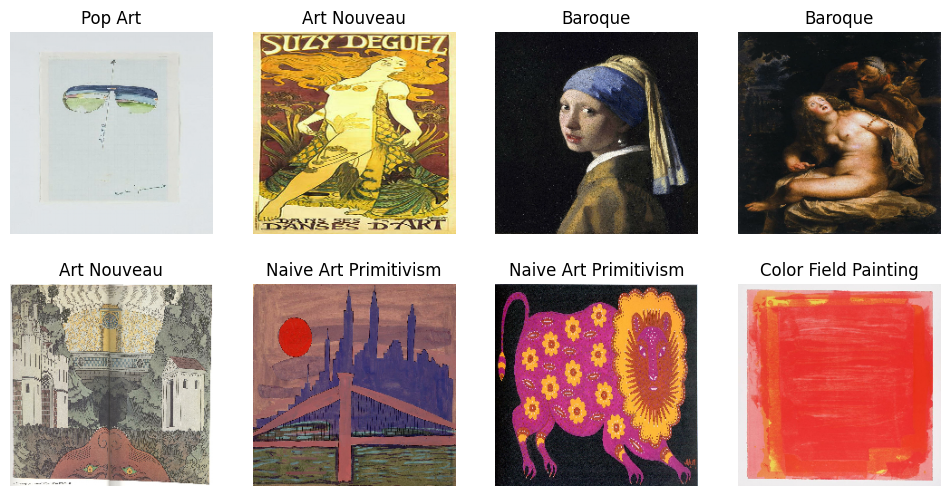

In [47]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(min(8, images.shape[0])):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy())
        label_idx = np.argmax(labels[i].numpy())
        plt.title(f"{grouped_styles[label_idx]}")
        plt.axis("off")
    plt.show()

In [48]:
from sklearn.utils import class_weight # For calculating class weights

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights calculated:")
for i, weight in class_weights_dict.items():
    print(f"  Class {grouped_styles[i]} (Index {i}): Weight {weight:.4f}")

Class weights calculated:
  Class Art Nouveau (Index 0): Weight 0.9882
  Class Baroque (Index 1): Weight 1.0067
  Class Color Field Painting (Index 2): Weight 1.0005
  Class Cubism (Index 3): Weight 1.0227
  Class Expressionism (Index 4): Weight 1.0309
  Class Fauvism (Index 5): Weight 1.0130
  Class Impressionism (Index 6): Weight 1.0052
  Class Minimalism (Index 7): Weight 1.0083
  Class Naive Art Primitivism (Index 8): Weight 1.0195
  Class Pop Art (Index 9): Weight 1.0178
  Class Realism (Index 10): Weight 0.9660
  Class Renaissance (Index 11): Weight 0.9822
  Class Rococo (Index 12): Weight 0.9646
  Class Romanticism (Index 13): Weight 1.0083
  Class Symbolism (Index 14): Weight 1.0099
  Class Ukiyo_e (Index 15): Weight 0.9632


In [49]:
unique_train_labels, train_counts = np.unique(y_train_labels, return_counts=True)
print("Training set class distribution:")
for label, count in zip(unique_train_labels, train_counts):
    print(f"Class {label} ({grouped_styles[label]}): {count} samples")

Training set class distribution:
Class 0 (Art Nouveau): 653 samples
Class 1 (Baroque): 641 samples
Class 2 (Color Field Painting): 645 samples
Class 3 (Cubism): 631 samples
Class 4 (Expressionism): 626 samples
Class 5 (Fauvism): 637 samples
Class 6 (Impressionism): 642 samples
Class 7 (Minimalism): 640 samples
Class 8 (Naive Art Primitivism): 633 samples
Class 9 (Pop Art): 634 samples
Class 10 (Realism): 668 samples
Class 11 (Renaissance): 657 samples
Class 12 (Rococo): 669 samples
Class 13 (Romanticism): 640 samples
Class 14 (Symbolism): 639 samples
Class 15 (Ukiyo_e): 670 samples


In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

## AlexNet





In [51]:
# vgg13 = Sequential([
#   # Block 1 (64 filters)
#   Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-3), input_shape=(224,224, 3)),
#   BatchNormalization(),
#   Activation('relu'),
#   Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(),
#   Activation('relu'),
#   MaxPooling2D((2, 2), strides=(2,2)),

#   # Block 2 (128 filters)
#   Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(),
#   Activation('relu'),
#   Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(),
#   Activation('relu'),
#   MaxPooling2D((2, 2), strides=(2,2)),

#   # Block 3 (256 filters)
#   Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(),
#   Activation('relu'),
#   Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(),
#   Activation('relu'),
#   MaxPooling2D((2, 2), strides=(2,2)),

#   # Block 4 (512 filters)
#   Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(),
#   Activation('relu'),
#   Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(),
#   Activation('relu'),
#   MaxPooling2D((2, 2), strides=(2,2)),

#   # Block 5 (optional, 512 filters, if image size allows further pooling)
#   # For 128x128, a 5th pooling layer would lead to 4x4 or 2x2.
#   Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(), Activation('relu'),
#   Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(), Activation('relu'),
#   MaxPooling2D((2, 2), strides=(2,2)),

#   # Classification Head (modified for common practice and Grad-CAM)
#   GlobalAveragePooling2D(),
#   BatchNormalization(), # After pooling
#   Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(),
#   Dropout(0.3),
#   Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
#   BatchNormalization(), # Added this
#   Dropout(0.3),
#   Dense(16, activation='softmax')
# ])

# alexNet = tf.keras.Sequential([
#   # Conv Layer 1
#   Conv2D(64, (11, 11), strides=4, padding='same', activation='relu', input_shape=(224, 224, 3)),
#   MaxPooling2D((3, 3), strides=2),

#   # Conv Layer 2
#   Conv2D(192, (5, 5), padding='same', activation='relu'),
#   MaxPooling2D((3, 3), strides=2),

#   # Conv Layer 3
#   Conv2D(384, (3, 3), padding='same', activation='relu'),

#   # Conv Layer 4
#   Conv2D(256, (3, 3), padding='same', activation='relu'),

#   # Conv Layer 5
#   Conv2D(256, (3, 3), padding='same', activation='relu'),
#   MaxPooling2D((3, 3), strides=2),

#   # Classifier
#   GlobalAveragePooling2D(),
#   Dense(512, activation='relu'),
#   Dropout(0.5),
#   Dense(512, activation='relu'),
#   Dropout(0.5),
#   Dense(16, activation='softmax')
# ], name='AlexNet')

alexNet = tf.keras.Sequential([
    # Conv Layer 1
    Conv2D(64, (11, 11), strides=4, padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(1e-3)),
    MaxPooling2D((3, 3), strides=2),

    # Conv Layer 2
    Conv2D(192, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(1e-3)),
    MaxPooling2D((3, 3), strides=2),

    # Conv Layer 3
    Conv2D(384, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-3)),

    # Conv Layer 4
    Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-3)),

    # Conv Layer 5
    Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-3)),
    MaxPooling2D((3, 3), strides=2),

    # Classifier
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
    Dropout(0.5),
    Dense(16, activation='softmax', kernel_regularizer=l2(1e-3))
], name='AlexNet')

In [52]:
alexNet.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        23296     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 192)       307392    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 192)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       663936    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       8849

In [53]:
from tensorflow.keras.callbacks import EarlyStopping


In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
base_optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

alexNet.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [55]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15,         
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001,      
)

In [56]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1, min_delta=0.0001)

In [57]:
# Clear any previous Keras sessions
tf.keras.backend.clear_session()

In [58]:
# Fit the model
history_alexNet = alexNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    callbacks=[early_stop, reduce_lr],
)


Epoch 1/500
323/323 [==============================] - 27s 73ms/step - loss: 3.8425 - accuracy: 0.0850 - val_loss: 3.3778 - val_accuracy: 0.1311 - lr: 1.0000e-04
Epoch 2/500
323/323 [==============================] - 28s 80ms/step - loss: 3.2149 - accuracy: 0.1378 - val_loss: 2.9492 - val_accuracy: 0.1790 - lr: 1.0000e-04
Epoch 3/500
323/323 [==============================] - 25s 71ms/step - loss: 2.9239 - accuracy: 0.1735 - val_loss: 2.7671 - val_accuracy: 0.2215 - lr: 1.0000e-04
Epoch 4/500
323/323 [==============================] - 26s 75ms/step - loss: 2.7817 - accuracy: 0.2032 - val_loss: 2.6833 - val_accuracy: 0.2423 - lr: 1.0000e-04
Epoch 5/500
323/323 [==============================] - 27s 77ms/step - loss: 2.6793 - accuracy: 0.2350 - val_loss: 2.5915 - val_accuracy: 0.2731 - lr: 1.0000e-04
Epoch 6/500
323/323 [==============================] - 27s 77ms/step - loss: 2.6131 - accuracy: 0.2533 - val_loss: 2.5687 - val_accuracy: 0.2740 - lr: 1.0000e-04
Epoch 7/500
323/323 [=======

In [65]:
# Normal
# print(history.history['accuracy'][-1])
# print(history.history['val_accuracy'][-1])

# AlexNet
print("Final training accuracy:", history_alexNet.history['accuracy'][-1])
print("Final validation accuracy:", history_alexNet.history['val_accuracy'][-1])

Final training accuracy: 0.665859580039978
Final validation accuracy: 0.4769439399242401


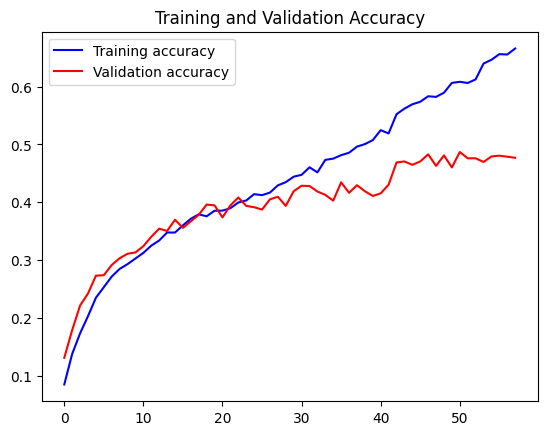

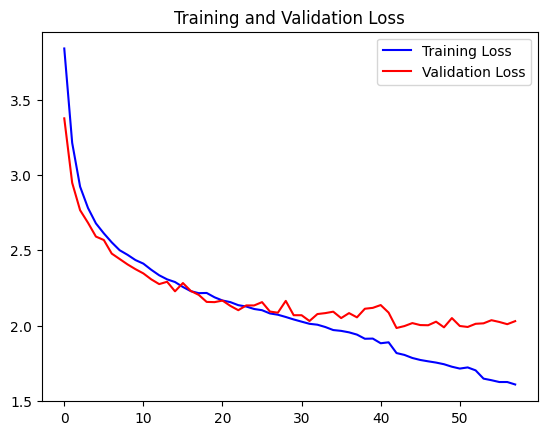

In [66]:
# Normal
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'b', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'b', label='Training Loss')
# plt.plot(epochs, val_loss, 'r', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# plt.show()

# AlexNet 
acc = history_alexNet.history['accuracy']
val_acc = history_alexNet.history['val_accuracy']
loss = history_alexNet.history['loss']
val_loss = history_alexNet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [61]:
alexNet.evaluate(test_ds)

70/70 [==============================] - 5s 65ms/step - loss: 2.0212 - accuracy: 0.4645


[2.021212100982666, 0.46452778577804565]

Selected random image at index 550
True class: Impressionism
1/1 [==============================] - 0s 277ms/step

Top 3 predictions for the sample image:
1. Romanticism: 0.230
2. Realism: 0.169
3. Symbolism: 0.153


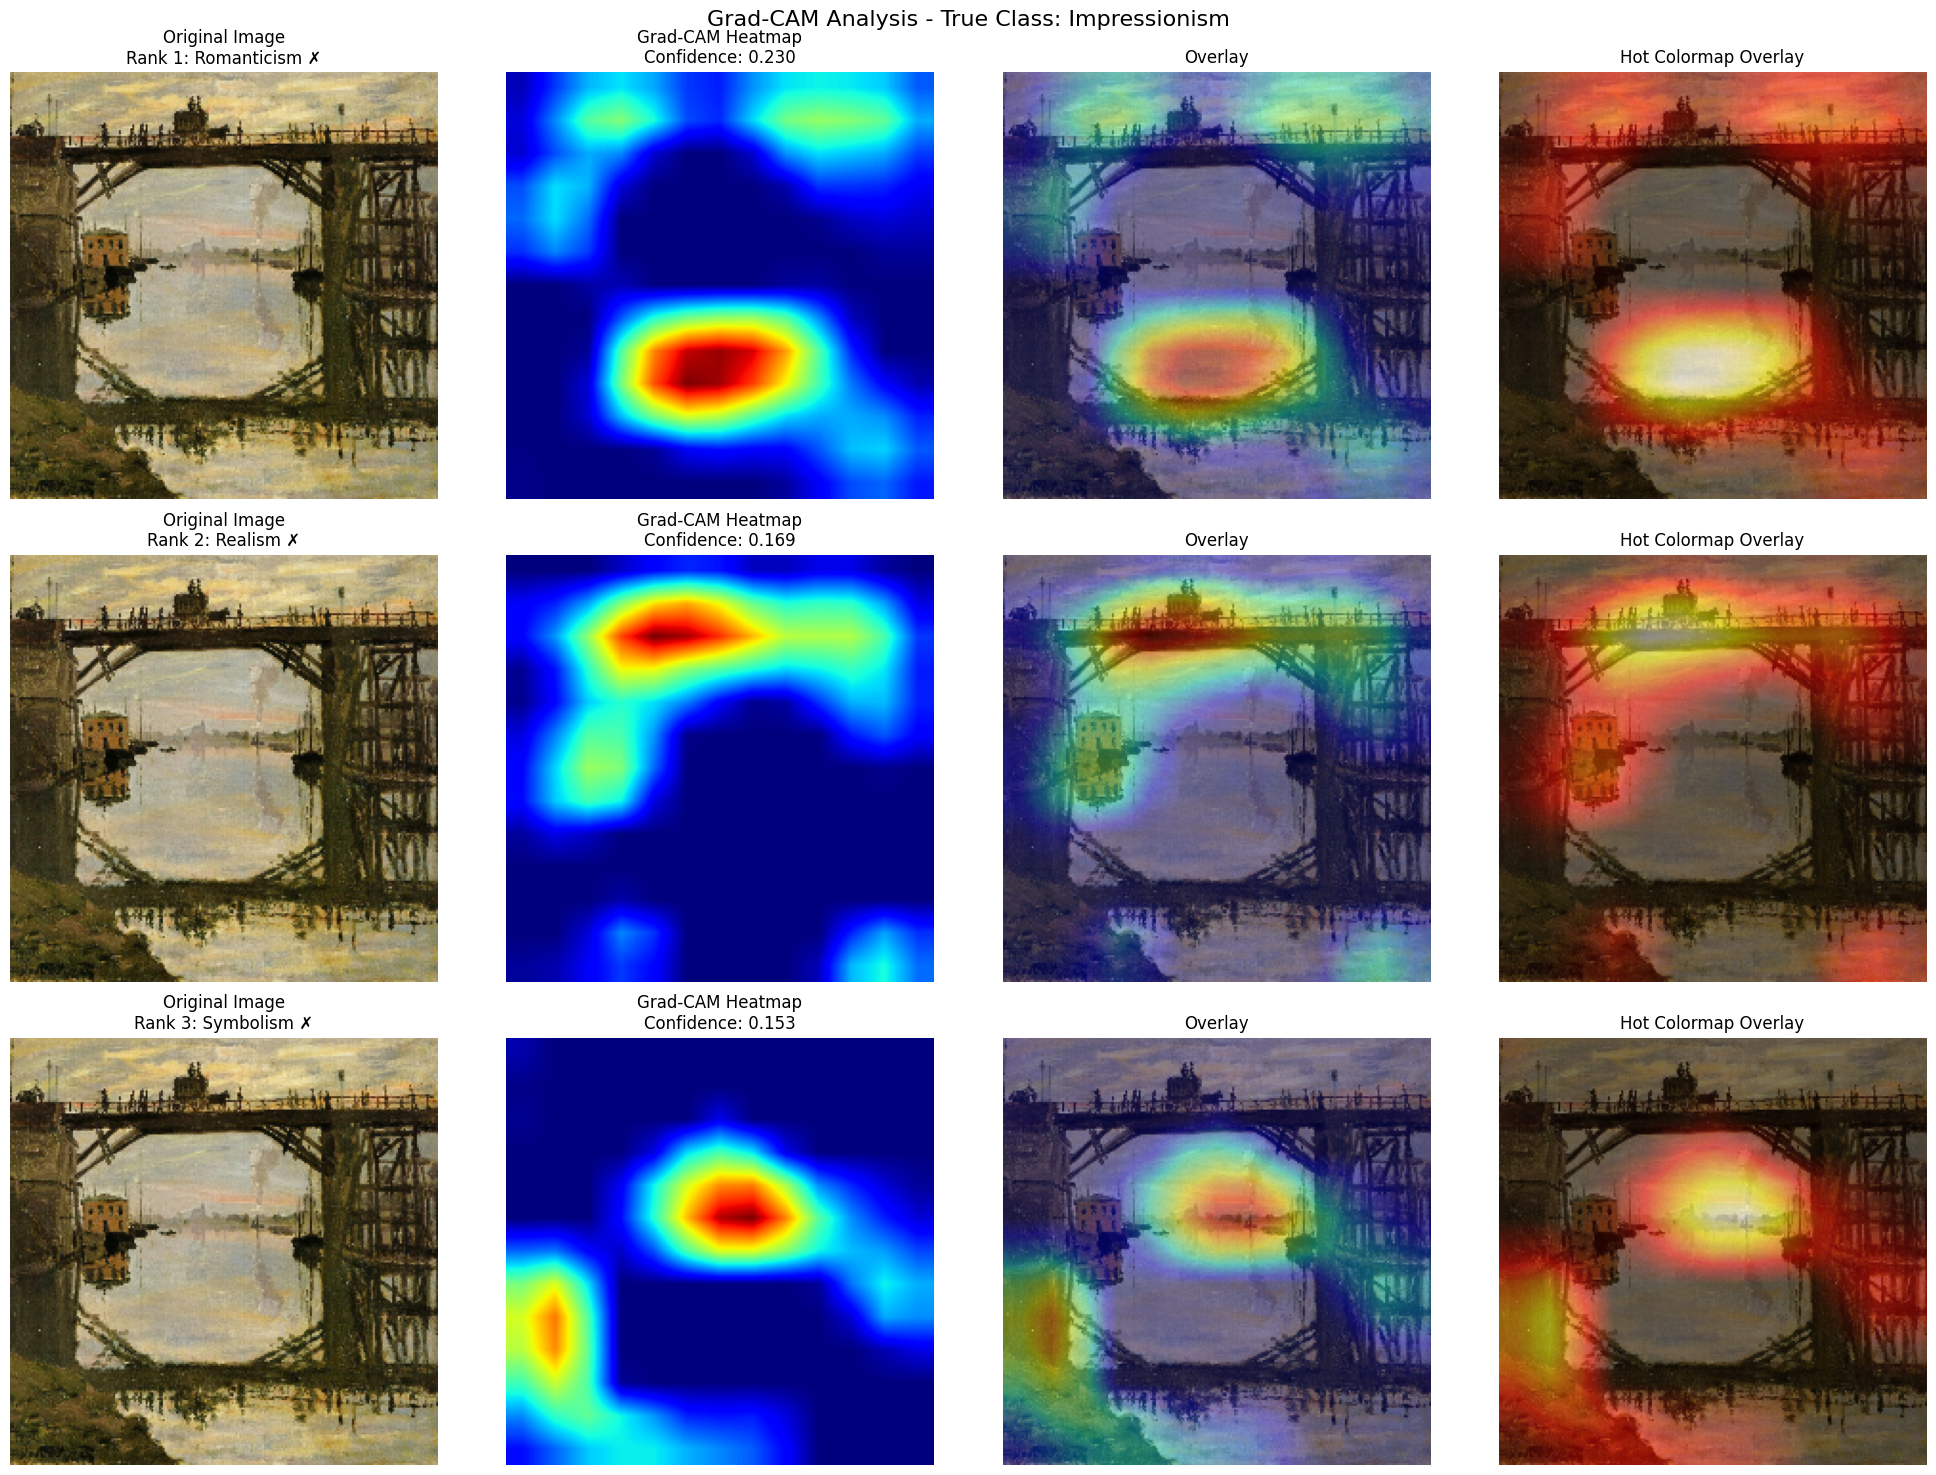

In [62]:
import numpy as np

# Select a random image from the test set
random_index = np.random.randint(0, len(X_test_paths))
sample_image_path = X_test_paths[random_index]
true_label = y_test_labels[random_index]

print(f"Selected random image at index {random_index}")
print(f"True class: {grouped_styles[true_label]}")

# Get the top 3 predicted classes for the sample image
sample_predictions = alexNet.predict(tf.expand_dims(tf.cast(tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(sample_image_path), channels=3), [224, 224]), tf.float32) / 255.0, axis=0))
top3_indices = np.argsort(sample_predictions[0])[-3:][::-1]  # Get top 3 in descending order
top3_probs = sample_predictions[0][top3_indices]

print(f"\nTop 3 predictions for the sample image:")
for i, (idx, prob) in enumerate(zip(top3_indices, top3_probs)):
    print(f"{i+1}. {grouped_styles[idx]}: {prob:.3f}")

# Define Grad-CAM function
def get_gradcam(model, img_array, layer_name, class_idx=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    
    # Extract the gradients of the top predicted class with regard to the output feature map
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Pool the gradients across the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    
    # Weight the feature map by the pooled gradients
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, output), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    # Resize heatmap to match input image size
    heatmap = tf.image.resize(tf.expand_dims(heatmap, -1), [224, 224])
    heatmap = tf.squeeze(heatmap)
    
    return heatmap.numpy()

# Visualize Grad-CAM for each of the top 3 classes
def visualize_gradcam_top3(model, image_path, top3_classes, top3_probs, true_class, layer_name='conv2d_4'):
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img_array = tf.cast(img, tf.float32) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)
    
    # Create visualization for top 3 classes
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    for i, (class_idx, prob) in enumerate(zip(top3_classes, top3_probs)):
        # Generate Grad-CAM heatmap for specific class
        heatmap = get_gradcam(model, img_array, layer_name, class_idx=class_idx)
        
        # Original image
        axes[i, 0].imshow(img_array[0])
        correct = "✓" if class_idx == true_class else "✗"
        axes[i, 0].set_title(f'Original Image\nRank {i+1}: {grouped_styles[class_idx]} {correct}')
        axes[i, 0].axis('off')
        
        # Heatmap
        axes[i, 1].imshow(heatmap, cmap='jet')
        axes[i, 1].set_title(f'Grad-CAM Heatmap\nConfidence: {prob:.3f}')
        axes[i, 1].axis('off')
        
        # Overlay
        axes[i, 2].imshow(img_array[0])
        axes[i, 2].imshow(heatmap, cmap='jet', alpha=0.4)
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')
        
        # Heatmap with different colormap for better contrast
        axes[i, 3].imshow(img_array[0])
        axes[i, 3].imshow(heatmap, cmap='hot', alpha=0.5)
        axes[i, 3].set_title('Hot Colormap Overlay')
        axes[i, 3].axis('off')
    
    plt.suptitle(f'Grad-CAM Analysis - True Class: {grouped_styles[true_class]}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Use the correct layer name from AlexNet (last conv layer)
visualize_gradcam_top3(alexNet, sample_image_path, top3_indices, top3_probs, true_label, layer_name='conv2d_4')


In [63]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = alexNet.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = y_test_labels
print(classification_report(y_test_classes, y_pred_classes, target_names=styles))

70/70 [==============================] - 4s 51ms/step
                       precision    recall  f1-score   support

          Art Nouveau       0.47      0.41      0.44       140
              Baroque       0.50      0.42      0.46       138
 Color Field Painting       0.75      0.61      0.67       138
               Cubism       0.56      0.39      0.46       135
        Expressionism       0.29      0.30      0.29       134
              Fauvism       0.44      0.32      0.37       136
        Impressionism       0.47      0.86      0.61       138
           Minimalism       0.62      0.54      0.58       137
Naive Art Primitivism       0.36      0.24      0.28       135
              Pop Art       0.45      0.43      0.44       136
              Realism       0.32      0.20      0.25       144
          Renaissance       0.45      0.62      0.52       141
               Rococo       0.41      0.60      0.49       143
          Romanticism       0.42      0.45      0.44       137


In [64]:
alexNet.save('model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(alexNet)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmphq_alnix\assets


INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmphq_alnix\assets


In [72]:
vgg11 = Sequential([
  # Block 1 (64 filters)
  Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-3), input_shape=(224,224, 3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 2 (128 filters)
  Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 3 (256 filters)
  Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 4 (512 filters)
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),

  # Block 5 (optional, 512 filters, if image size allows further pooling)
  # For 128x128, a 5th pooling layer would lead to 4x4 or 2x2.
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), Activation('relu'),
  Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), Activation('relu'),
  MaxPooling2D((2, 2), strides=(2,2)),


  GlobalAveragePooling2D(),
  BatchNormalization(), # After pooling
  Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
  BatchNormalization(), # Added this
  Dropout(0.3),
  Dense(16, activation='softmax')
])

In [73]:
# Define the model
vgg11.build(input_shape=(image_height, image_width, 3))
vgg11.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_24 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_25 (Bat  (None, 112, 112, 128)   

In [74]:
# Initialize starting learning rate
base_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg11.compile(
    optimizer=base_optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
    metrics=['accuracy']
)

In [78]:
# Fit the model
history_vgg11 = vgg11.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stop, reduce_lr],
    # class_weight = class_weights_dict only used if class imbalance is significant
)

Epoch 1/1000
323/323 [==============================] - 123s 375ms/step - loss: 6.1659 - accuracy: 0.2449 - val_loss: 7.0283 - val_accuracy: 0.1035 - lr: 1.0000e-04
Epoch 2/1000
323/323 [==============================] - 121s 368ms/step - loss: 5.8872 - accuracy: 0.2857 - val_loss: 5.9374 - val_accuracy: 0.3083 - lr: 1.0000e-04
Epoch 3/1000
323/323 [==============================] - 121s 369ms/step - loss: 5.6634 - accuracy: 0.3136 - val_loss: 5.4541 - val_accuracy: 0.3314 - lr: 1.0000e-04
Epoch 4/1000
323/323 [==============================] - 121s 369ms/step - loss: 5.4686 - accuracy: 0.3391 - val_loss: 5.9596 - val_accuracy: 0.2717 - lr: 1.0000e-04
Epoch 5/1000
323/323 [==============================] - 121s 369ms/step - loss: 5.2812 - accuracy: 0.3579 - val_loss: 5.0275 - val_accuracy: 0.4019 - lr: 1.0000e-04
Epoch 6/1000
323/323 [==============================] - 124s 378ms/step - loss: 5.0865 - accuracy: 0.3739 - val_loss: 5.1372 - val_accuracy: 0.3522 - lr: 1.0000e-04
Epoch 7/10

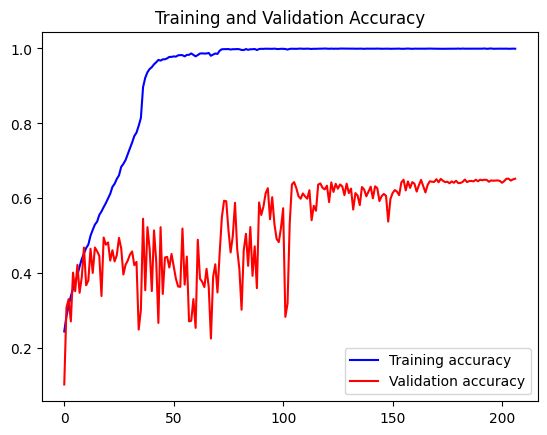

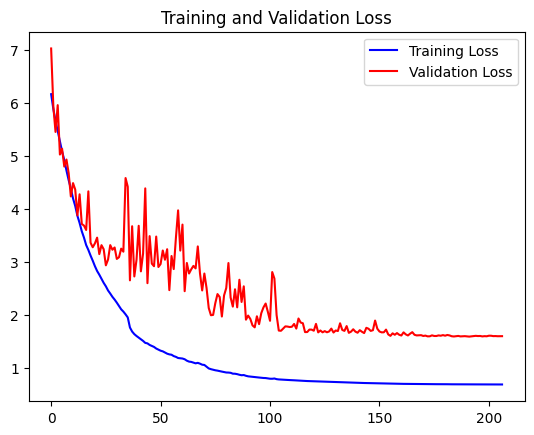

In [79]:
acc = history_vgg11.history['accuracy']
val_acc = history_vgg11.history['val_accuracy']
loss = history_vgg11.history['loss']
val_loss = history_vgg11.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [80]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = vgg11.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Correct way to get true labels for comparison
y_true_labels_one_hot = []
for _, y_batch in test_ds:
    y_true_labels_one_hot.append(y_batch.numpy())

# Concatenate all one-hot batches and then convert them to integer labels
y_true_classes = np.argmax(np.concatenate(y_true_labels_one_hot, axis=0), axis=1)


print("Classification Report:")
# Ensure target_names matches the order of your class indices
print(classification_report(y_true_classes, y_pred_classes, target_names=grouped_styles))

70/70 [==============================] - 7s 96ms/step
Classification Report:
                       precision    recall  f1-score   support

          Art Nouveau       0.68      0.60      0.64       140
              Baroque       0.58      0.51      0.55       138
 Color Field Painting       0.76      0.77      0.76       138
               Cubism       0.74      0.81      0.77       135
        Expressionism       0.48      0.41      0.44       134
              Fauvism       0.51      0.56      0.54       136
        Impressionism       0.69      0.89      0.78       138
           Minimalism       0.71      0.65      0.68       137
Naive Art Primitivism       0.53      0.60      0.56       135
              Pop Art       0.58      0.64      0.61       136
              Realism       0.55      0.45      0.49       144
          Renaissance       0.61      0.70      0.65       141
               Rococo       0.72      0.63      0.67       143
          Romanticism       0.51      0.

In [81]:
test_loss, test_accuracy = vgg11.evaluate(test_ds)


70/70 [==============================] - 7s 94ms/step - loss: 1.6481 - accuracy: 0.6308


In [82]:
# Print the test accuracy and loss
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.6481
Test Accuracy: 0.6308


In [83]:
# Save the model as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(vgg11)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('vgg11_gradcam.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Save the model in HDF5 format
vgg11.save('vgg11_gradcam.h5')

# Save the model in SavedModel format
vgg11.save('vgg11_gradcam_saved_model', save_format='tf')

# Save the keras model
vgg11.save('vgg11_gradcam.keras')

INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmp95qu3c1i\assets


INFO:tensorflow:Assets written to: C:\Users\Coli\AppData\Local\Temp\tmp95qu3c1i\assets


INFO:tensorflow:Assets written to: vgg11_gradcam_saved_model\assets


INFO:tensorflow:Assets written to: vgg11_gradcam_saved_model\assets
